## Import libs

In [41]:
!pip install scikit-learn
!pip install transformers
!pip install tqdm
!pip install datasets
!pip install nltk

import os

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import torch

#from progressbar import progressbar
from tqdm.auto import tqdm
from collections import defaultdict

def load_datasets(benchmark_name: str, dataset_names, cut_len=None):
    ans = {}
    for name in dataset_names:
        dataset = load_dataset(benchmark_name, name)
        ans[f'{name}'] = dataset
    if cut_len is not None:
        ans = cut_datasets(ans, cut_len)
    return ans

def cut_datasets(
    datasets,
    cut_len:int = 100
):
    for dataset_name, dataset in datasets.items():
        for dataset_split_name, dataset_split in dataset.items():
            new_split = dataset_split[:cut_len]
            if isinstance(new_split, dict):
                new_split = [dict(zip(new_split,t)) for t in zip(*new_split.values())]
            datasets[dataset_name][dataset_split_name] = new_split
    return datasets

## Define hyperparams

In [2]:
# Define datasets
#['mrpc', 'sst2', 'cola', 'rte', 'qnli']
glue_classification = {'mrpc': ['sentence1', 'sentence2']} #, 'sst2':  ['sentence']}
superglue_classification = {'wic': ['sentence1', 'sentence2']}
all_classification = {'glue': glue_classification, 'superglue': superglue_classification}

model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=1024)
model = AutoModel.from_pretrained(model_name)
model.eval()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


model.to(device)
DEBUG_FLAG = True
CUT_SIZE = None if not DEBUG_FLAG else 200

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Load datasets

In [3]:
glue_datasets = load_datasets('glue', list(glue_classification), CUT_SIZE)
superglue_datasets = load_datasets('super_glue', list(superglue_classification), CUT_SIZE)

all_datasets = {'glue': glue_datasets, 'superglue': superglue_datasets}

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## Collect dataset for layers and heads

In [4]:
!pip install h5py

In [5]:
import numpy as np
import json
import h5py
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

In [6]:
X_train = []
y_train = []

for ex_idx, ex in tqdm(enumerate(glue_datasets['mrpc']['train'])):
    encoded_inputs = tokenizer.encode(
                    ex['sentence1'],
                    ex['sentence2'],
                    truncation=True,
                    return_tensors='pt'
                ).to(device)
    aa = model(encoded_inputs, output_hidden_states=True, output_attentions=True)

    for layer in [9]:
        if not os.path.exists(f'/data/workspace_files/mrpc/layer_{layer}'):
            os.makedirs(f'/data/workspace_files/mrpc/layer_{layer}')

        for head_num in [6]: #range(aa.attentions[0].shape[1]):
            if not os.path.exists(f'/data/workspace_files/mrpc/layer_{layer}/head_{head_num}'):
                os.makedirs(f'/data/workspace_files/mrpc/layer_{layer}/head_{head_num}')

            current_hidden_states = aa.hidden_states[layer][0].detach().cpu().numpy()
            next_hidden_states = aa.hidden_states[layer + 1][0].detach().cpu().numpy()
            attentions = aa.attentions[layer][0][head_num].detach().cpu().numpy() # .item()

            cur_emb = aa.hidden_states[layer][0]
            val_proj = model.encoder.layer[layer].attention.self.value(cur_emb).detach().cpu().numpy()
            key_proj = model.encoder.layer[layer].attention.self.key(cur_emb).detach().cpu().numpy()
            que_proj = model.encoder.layer[layer].attention.self.query(cur_emb).detach().cpu().numpy()

            with h5py.File(f'/data/workspace_files/mrpc/layer_{layer}/head_{head_num}/{ex_idx}.hdf5', 'w') as f:
                f.create_dataset("current_hidden_states", data=current_hidden_states)
                f.create_dataset("next_hidden_states", data=next_hidden_states)
                f.create_dataset("attentions", data=attentions)
                f.create_dataset("val_proj", data=val_proj)
                f.create_dataset("key_proj", data=key_proj)
                f.create_dataset("que_proj", data=que_proj)

200it [01:30,  2.20it/s]


In [7]:
def get_dataset_for_regression(prob_of_take=0.3, layer=0, head_num=0):
    X_train, y_train = [], []
    X_test, y_test = [], []
    length = len(glue_datasets['mrpc']['train'])
    for ex_idx, ex in tqdm(enumerate(glue_datasets['mrpc']['train'])):
        encoded_inputs = tokenizer.encode(
                            ex['sentence1'],
                            ex['sentence2'],
                            truncation=True,
                            return_tensors='pt'
                        )
        special_symbols = (encoded_inputs[0] < 103).nonzero().squeeze()
        with h5py.File(f'/data/workspace_files/mrpc/layer_{layer}/head_{head_num}/{ex_idx}.hdf5', 'r') as f:

            current_hidden_states = f['current_hidden_states'][()]
            next_hidden_states = f['next_hidden_states'][()]
            attentions = f['attentions'][()]

            val_proj = f['val_proj'][()]
            key_proj = f['key_proj'][()]
            que_proj = f['que_proj'][()]

            len_of_seq = attentions.shape[0]
            for from_ in range(len_of_seq):
                for to_ in range(len_of_seq):
                    if np.random.choice([0, 1], size=1, p=[1-prob_of_take, prob_of_take])[0] > 0.5:
                        feature_vector = []
                        # (pos form, pos to, is_from_special_token, is_to_special_token,
                        # len_of_seq, rel_position_from, rel_position_to, rev_pos_from, rev_pos_to, to_emb)


                        feature_vector.append(from_) # from_ pos
                        feature_vector.append(to_) # to_ pos

                        is_from_special_token = int(from_ in special_symbols)
                        is_to_special_token = int(to_ in special_symbols)
                        feature_vector.append(is_from_special_token)
                        feature_vector.append(is_to_special_token)
                        feature_vector.append(len_of_seq)
                        feature_vector.append(from_/len_of_seq)
                        feature_vector.append(to_/len_of_seq)
                        feature_vector.append(len_of_seq - from_)
                        feature_vector.append(len_of_seq - to_)
                        feature_vector += list(current_hidden_states[to_])


                        if ex_idx < length*0.85:
                            X_train.append(feature_vector)
                            y_train.append(attentions[from_, to_])
                        else:
                            X_test.append(feature_vector)
                            y_test.append(attentions[from_, to_])
    return X_train, y_train, X_test, y_test

In [8]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from statistics import mean

def learn(model, y_scaler, reverse_scaler, X_train, y_train, X_test, y_test, feature_names, num_examples = 1):
    # y_scaler = StandardScaler()
    y_train_scaled = y_scaler(y_train.reshape(-1, 1))
    y_test_scaled = y_scaler(y_test.reshape(-1, 1))
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)


    print('Y train mean:', np.mean(y_train_scaled))
    print('Y test mean:', np.mean(y_test_scaled))

    print('Mean cross val R2:', np.mean(cross_val_score(model, X_train, y_train_scaled, cv=5, scoring='r2')))

    model.fit(X_train, y_train_scaled)
    preds_scaled = model.predict(X_test)
    preds = reverse_scaler(preds_scaled)

    r2_score_test = r2_score(y_test, preds)
    print('Test R2:', r2_score_test)
    print('\nPredictions:')
    samples = np.random.choice(len(X_test), size=num_examples, replace=False)
    for i in samples:
        print(f'Pred = {preds[i][0]} and target = {y_test_scaled[i][0]}')

    fig, ax = plt.subplots(1, 2, figsize = (8, 4))


    # # Plot the distribution of y_train_scaled
    # sns.displot(y_train_scaled, label='Y train distribution')
    #  # Plot the distribution of y_test_scaled
    # sns.displot(y_test_scaled,label='Y test distribution')


    # Scatter plot of predictions vs. actual values
    ax[0].scatter(y_test, preds)
    ax[0].set_xlabel('Actual Values')
    ax[0].set_ylabel('Predictions')
    ax[0].set_title('Predictions vs. Actual Values')

    if hasattr(model, 'coef_'):
        if type(feature_names) == dict:
          feature_importance = []
          for i in feature_names.values():
            feature_importance.append(max(list(map(abs, model.coef_[0, i]))))
          feature_names = feature_names.keys()
        else: feature_importance = [abs(i) for i in model.coef_[0]]

        ax[1].bar(feature_names, feature_importance)
        ax[1].set_xlabel('Features')
        ax[1].set_ylabel('Importance')
        ax[1].set_title('Feature Importance')
        ax[1].set_xticklabels(feature_names, rotation=90)

    plt.tight_layout()
    plt.show()


    return model

## Layer 9

In [10]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=9, head_num=6)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X_train.shape, X_test.shape

200it [01:42,  1.95it/s]


((153470, 777), (27418, 777))

In [11]:
id_scaler = lambda x: [el for el in x]
log_scaler = lambda x: np.log(x * 100 + 1)
log_reverse = lambda x: (np.exp(x) - 1) / 100

## Round 1
Checking len, relative positions, emb_to, poly features

### Only positions as features (layer 9)

Y train mean: 0.01772779
Y test mean: 0.018020261
Mean cross val R2: 0.0054270243761114
Test R2: 0.00603622737341214

Predictions:
Pred = 0.01418040065864547 and target = 0.007196422666311264


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


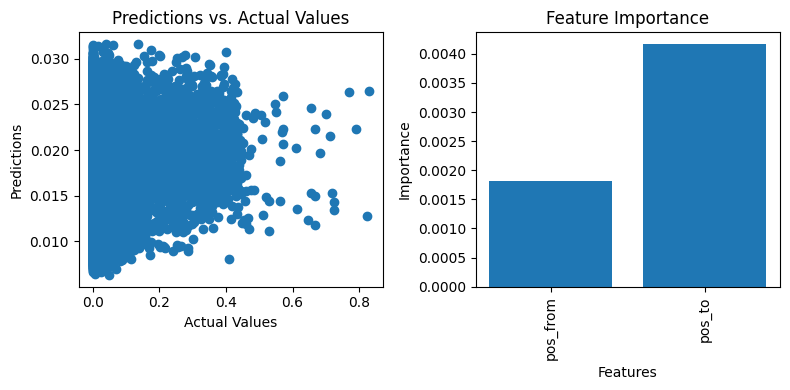

In [13]:
learn(Ridge(), id_scaler, id_scaler, X_train[:, [0,1]], y_train, X_test[:, [0,1]], y_test, ['pos_from', 'pos_to'])
None

Y train mean: 0.01772779
Y test mean: 0.018020261
Mean cross val R2: 0.0054270243761114
Test R2: 0.00603622737341214

Predictions:
Pred = 0.0219217088742243 and target = 0.005729135125875473


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


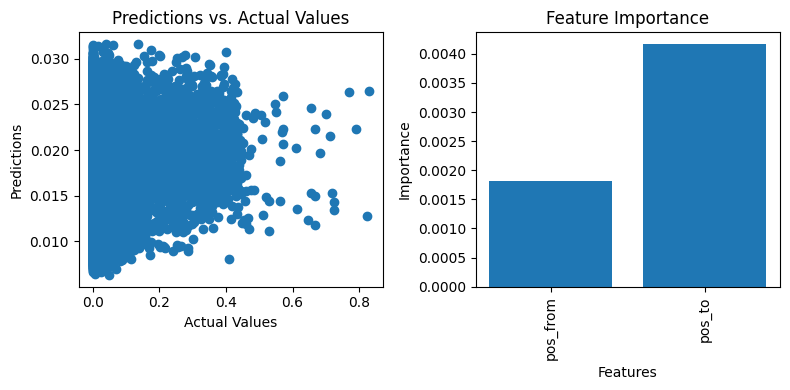

In [14]:
learn(Ridge(), id_scaler, id_scaler, X_train[:, [0,1]], y_train, X_test[:, [0,1]], y_test, ['pos_from', 'pos_to'])
None

### Add len as feature (layer 9)

Y train mean: 0.01772779
Y test mean: 0.018020261
Mean cross val R2: 0.013289899975204956
Test R2: 0.013456883023584498

Predictions:
Pred = 0.022663962355401905 and target = 0.0007592827314510942


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


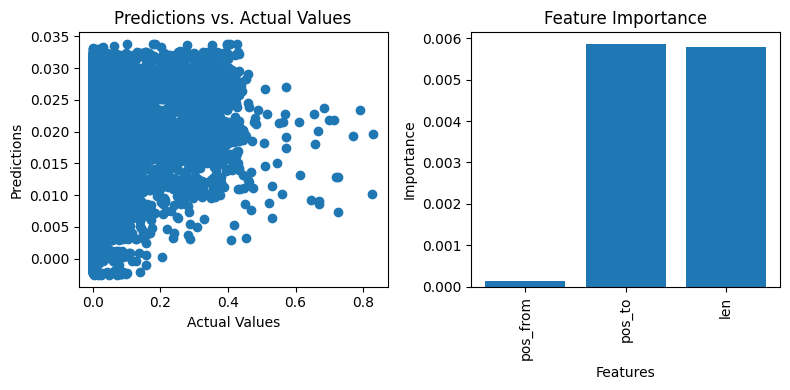

In [15]:
learn(Ridge(), id_scaler, id_scaler, X_train[:, [0, 1, 4]], y_train, X_test[:, [0, 1, 4]], y_test, ['pos_from', 'pos_to', 'len'])
None

Y train mean: 0.4265724
Y test mean: 0.43790463
Mean cross val R2: 0.016184081461372825
Test R2: -0.03975270552560639

Predictions:
Pred = 0.006711714997096747 and target = 1.5044798851013184


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


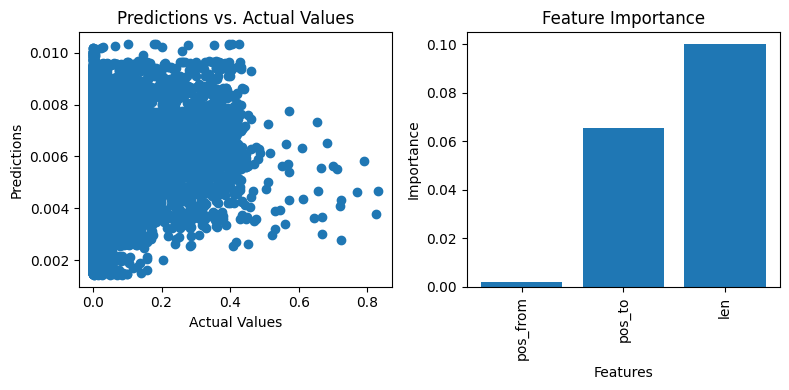

In [16]:
learn(Ridge(), log_scaler, log_reverse, X_train[:, [0,1,4]], y_train, X_test[:, [0,1,4]], y_test, ['pos_from', 'pos_to', 'len'])
None

### Add relative positions as features (layer 9)

Y train mean: 0.01772779
Y test mean: 0.018020261
Mean cross val R2: 0.016487957339838565
Test R2: 0.01700306572911503

Predictions:
Pred = 0.00827868583623726 and target = 0.00038620748091489077


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


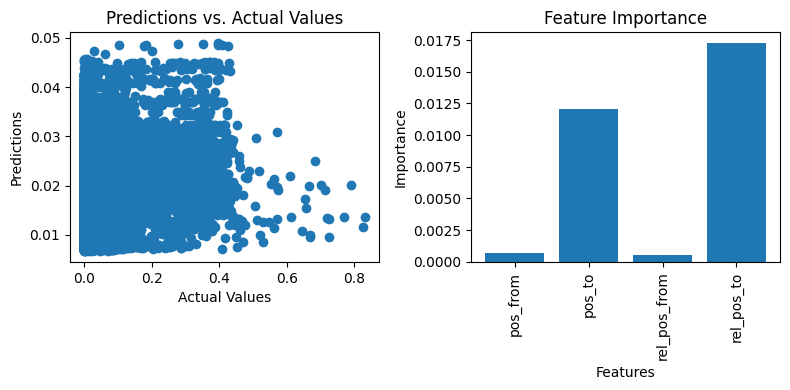

In [17]:
learn(Ridge(), id_scaler, id_scaler, X_train[:, [0, 1, 5, 6]], y_train, X_test[:, [0, 1, 5,6]], y_test, ['pos_from', 'pos_to', 'rel_pos_from', 'rel_pos_to'])
None

Y train mean: 0.4265724
Y test mean: 0.43790463
Mean cross val R2: 0.016920372735354537
Test R2: -0.038831513623542646

Predictions:
Pred = 0.005460233736676961 and target = 2.1499640941619873


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


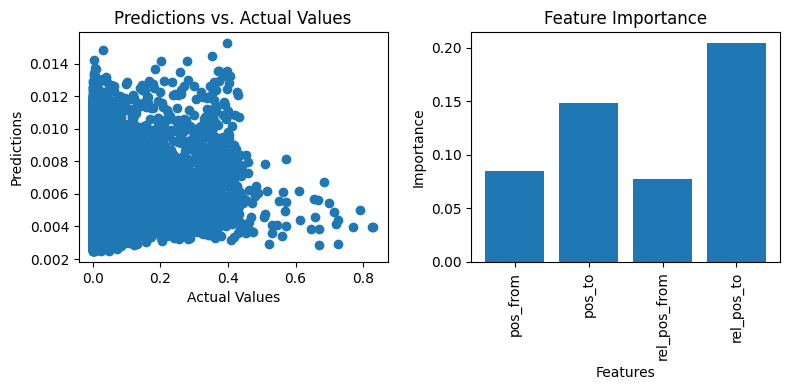

In [18]:
learn(Ridge(), log_scaler, log_reverse, X_train[:, [0,1,5, 6]], y_train, X_test[:, [0,1,5, 6]], y_test, ['pos_from', 'pos_to', 'rel_pos_from', 'rel_pos_to'])
None

### Add embedding_to as features (layer 9)

Y train mean: 0.01772779
Y test mean: 0.018020261
Mean cross val R2: 0.5043877045133703
Test R2: 0.5436607078772577

Predictions:
Pred = 0.010137353065008526 and target = 0.003272025613114238


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


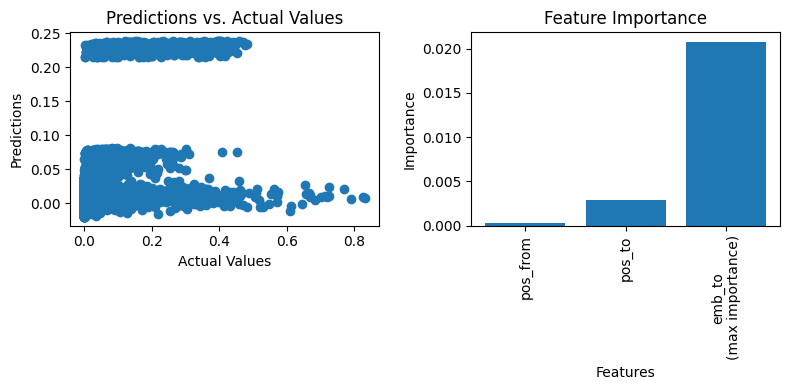

In [23]:
lst_features = [0, 1]+list(range(9, 777))
learn(Ridge(), id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test, {'pos_from': [0], 'pos_to':[1], 'emb_to\n(max importance)': list(range(2,768))})
None

Y train mean: 0.4265724
Y test mean: 0.43790463
Mean cross val R2: 0.6034687653842903
Test R2: 0.5353657390222772

Predictions:
Pred = 0.0011961974051498058 and target = 0.1411571502685547


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


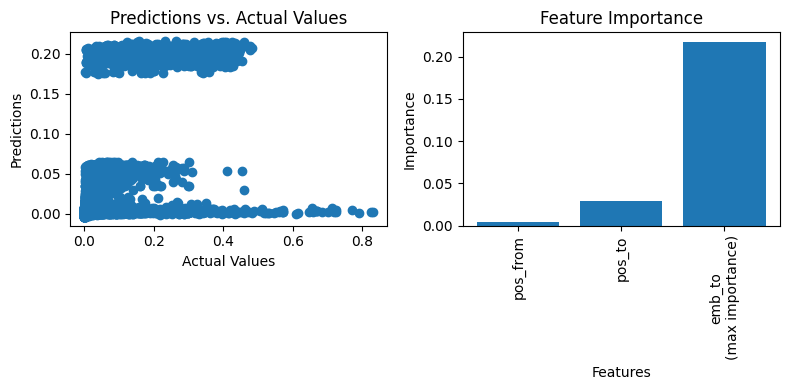

In [24]:
lst_features = [0, 1]+list(range(9, 777))
learn(Ridge(), log_scaler, log_reverse, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test, {'pos_from': [0], 'pos_to':[1], 'emb_to\n(max importance)': list(range(2,768))})
None

### Add reversed positions as features (layer 9)

Y train mean: 0.01799294
Y test mean: 0.017006788
Mean cross val R2: 0.014809345717196809
Test R2: 0.01566963763571194

Predictions:
Pred = 0.020634095993081733 and target = 0.0001261972647625953


<ipython-input-27-195d770658cd>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


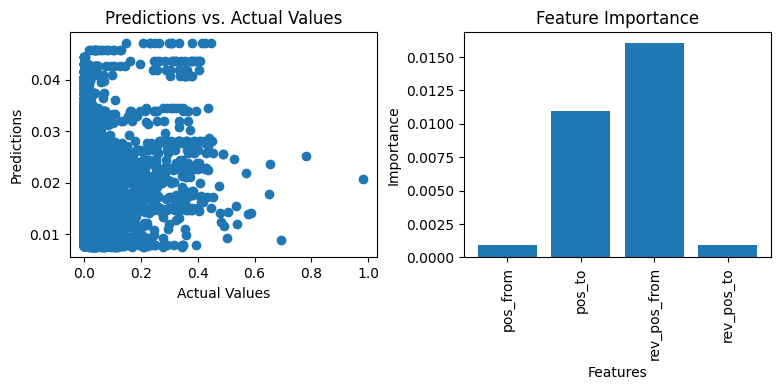

Y train mean: 0.43075323
Y test mean: 0.41927233
Mean cross val R2: 0.01627645701226841


<ipython-input-27-195d770658cd>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


Test R2: -0.0328997960562869

Predictions:
Pred = 0.005752034905760748 and target = 1.984292984008789


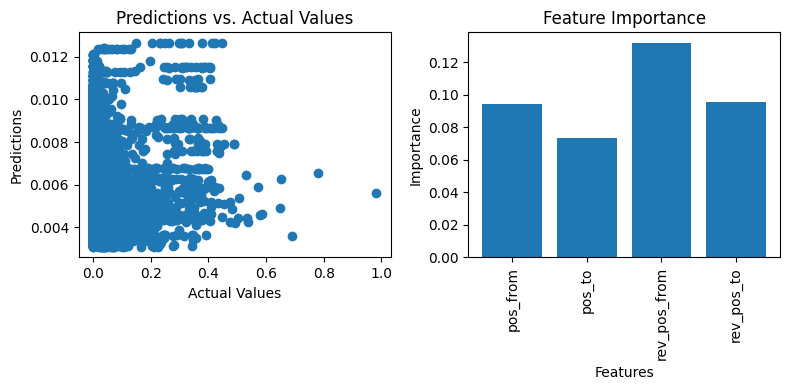

In [ ]:
lst_features = [0, 1, 6, 7]
learn(Ridge(), id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test, ['pos_from', 'pos_to', 'rev_pos_from', 'rev_pos_to'])
learn(Ridge(), log_scaler, log_reverse, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test, ['pos_from', 'pos_to', 'rev_pos_from', 'rev_pos_to'])
None

### Add poly 4 of positions as features (layer 9)

Y train mean: 0.017657457
Y test mean: 0.0172931
Mean cross val R2: 0.010752046988939412
Test R2: 0.018242269234796216

Predictions:
Pred = 0.01294154115488283 and target = 0.00011639610602287576


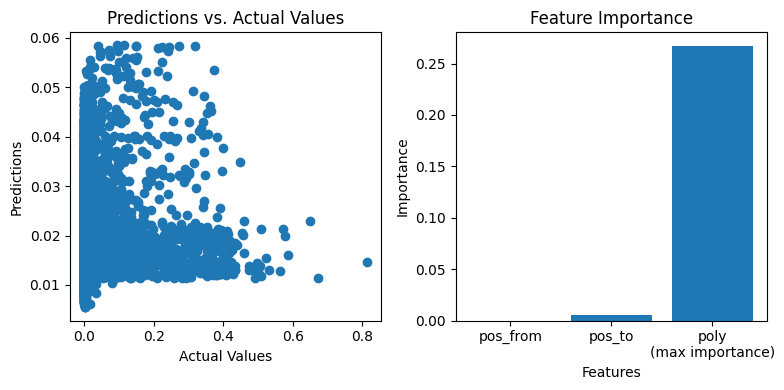

In [ ]:
X_train_poly = PolynomialFeatures(degree=4).fit_transform(X_train[:, [0, 1]])
X_test_poly = PolynomialFeatures(degree=4).fit_transform(X_test[:, [0, 1]])
# X_test_poly.shape[1]
learn(Ridge(), id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, {'pos_from': [0], 'pos_to':[1], 'poly\n(max importance)': list(range(2,X_test_poly.shape[1]-2))})
None

Y train mean: 0.4286012
Y test mean: 0.42521188
Mean cross val R2: 0.023300030572783913
Test R2: -0.03135606641576505

Predictions:
Pred = 0.003982683571194103 and target = 0.42952102422714233


<ipython-input-14-195d770658cd>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


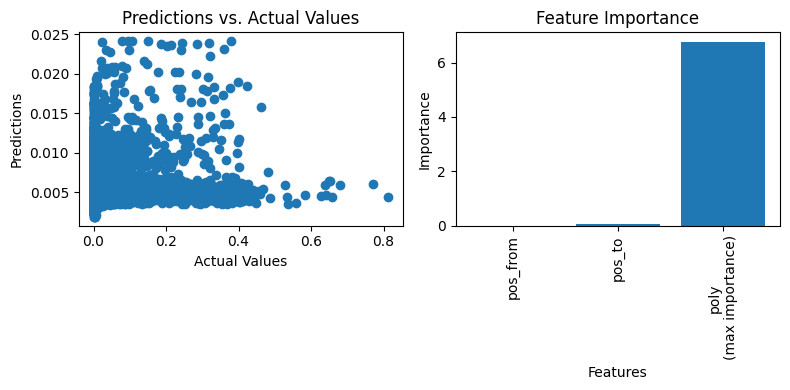

In [ ]:
X_train_poly = PolynomialFeatures(degree=4).fit_transform(X_train[:, [0, 1]])
X_test_poly = PolynomialFeatures(degree=4).fit_transform(X_test[:, [0, 1]])
# X_test_poly.shape[1]
learn(Ridge(), log_scaler, log_reverse, X_train_poly, y_train, X_test_poly, y_test, {'pos_from': [0], 'pos_to':[1], 'poly\n(max importance)': list(range(2,X_test_poly.shape[1]-2))})
None

### Add is_special_token as features (layer 9)

Y train mean: 0.017657457
Y test mean: 0.0172931
Mean cross val R2: 0.4030259315577097
Test R2: 0.4025683818690302

Predictions:
Pred = 0.009400567260118705 and target = 2.2114089006208815e-05


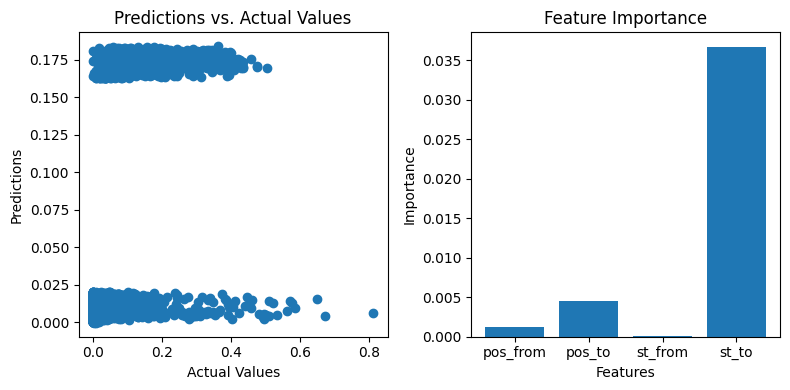

In [ ]:
learn(Ridge(), id_scaler, id_scaler, X_train[:,[0,1,2,3]], y_train, X_test[:,[0,1,2,3]], y_test, ['pos_from','pos_to','st_from', 'st_to'])
None

Y train mean: 0.42595708
Y test mean: 0.42349973
Mean cross val R2: 0.43257458177759284
Test R2: 0.3663410491315561

Predictions:
Pred = 0.0033729545233969383 and target = 0.004547136835753918


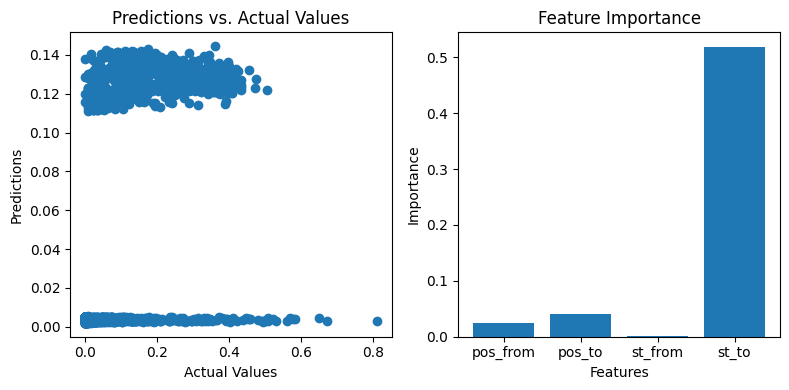

In [ ]:
learn(Ridge(), log_scaler, log_reverse, X_train[:,[0,1,2,3]], y_train, X_test[:,[0,1,2,3]], y_test, ['pos_from','pos_to','st_from', 'st_to'])
None

## Round 2

### Add len and relative positions (layer 9)

Y train mean: 0.01769374
Y test mean: 0.017827563
Mean cross val R2: 0.013658495847524165
Test R2: 0.019708667419948478

Predictions:
Pred = 0.01142726798901651 and target = 1.5363615602836944e-05


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


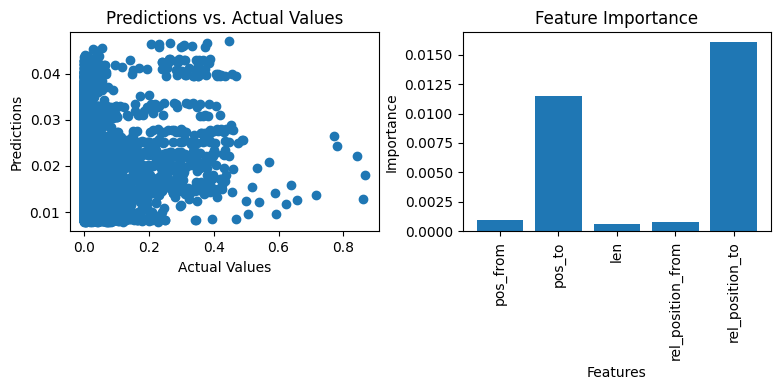

In [13]:
lst_features = [0, 1, 4, 5, 6]
feature_names = ['pos_from', 'pos_to', 'len', 'rel_position_from', 'rel_position_to']
learn(Ridge(), id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
None

Y train mean: 0.42494953
Y test mean: 0.42876744
Mean cross val R2: 0.016145863890081037
Test R2: -0.035072294912291024

Predictions:
Pred = 0.0058968819912322435 and target = 0.01780584827065468


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


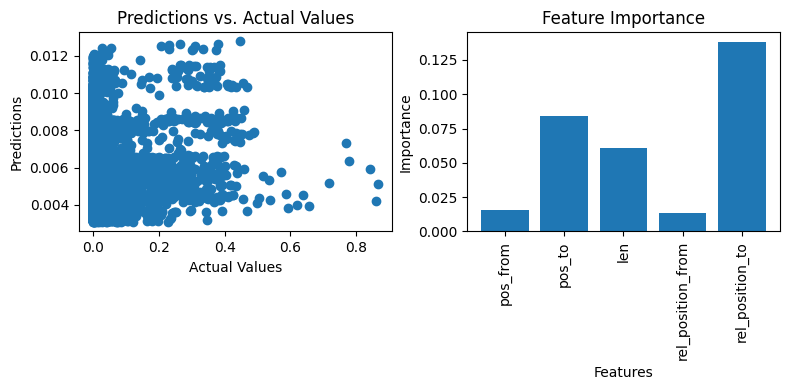

In [14]:
learn(Ridge(), log_scaler, log_reverse, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test, feature_names)
None

### Add len and reversed positions (layer 9)

Y train mean: 0.01769374
Y test mean: 0.017827563
Mean cross val R2: 0.01365742103831007
Test R2: 0.01974088610097635

Predictions:
Pred = 0.010226563440758188 and target = 8.752729627303779e-05


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


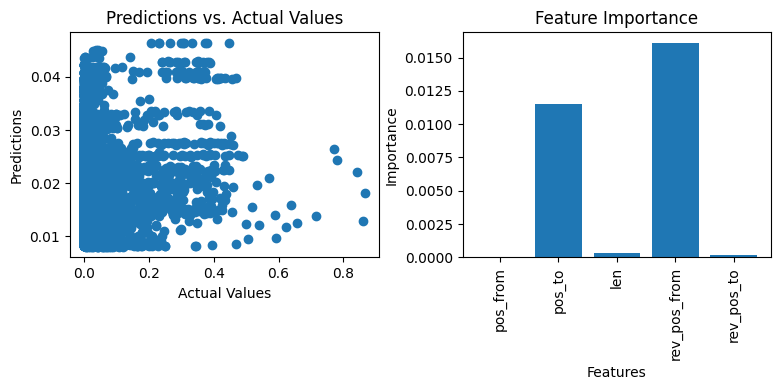

Y train mean: 0.42494953
Y test mean: 0.42876744
Mean cross val R2: 0.01615135911547385
Test R2: -0.035049683364621664

Predictions:
Pred = 0.006015302760779464 and target = 0.08423557132482529


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


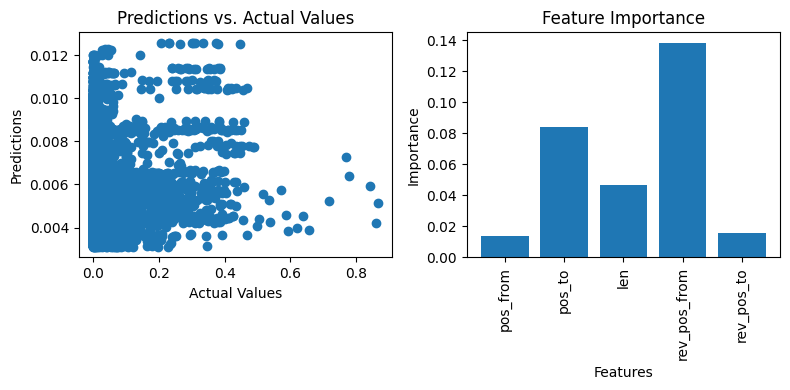

In [15]:
lst_features = [0, 1, 4, 6, 7]
learn(Ridge(), id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test, ['pos_from', 'pos_to', 'len','rev_pos_from', 'rev_pos_to'])
learn(Ridge(), log_scaler, log_reverse, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test, ['pos_from', 'pos_to','len', 'rev_pos_from', 'rev_pos_to'])
None

### Add len and embedding_to (layer 9)

Y train mean: 0.01769374
Y test mean: 0.017827563
Mean cross val R2: 0.49028058060937224
Test R2: 0.48039028659938365

Predictions:
Pred = 0.001334728536768092 and target = 0.0014188468921929598


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


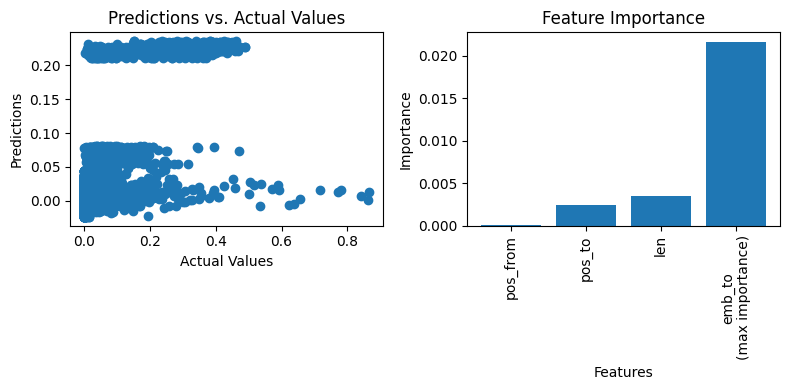

Y train mean: 0.42494953
Y test mean: 0.42876744
Mean cross val R2: 0.587498886096046
Test R2: 0.4862555326311856

Predictions:
Pred = 0.0018369526185143404 and target = 0.017361098900437355


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


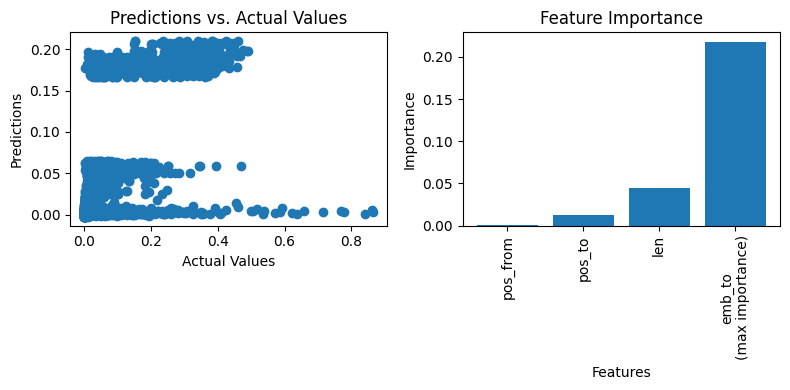

In [16]:
### Add len and embedding_to (layer 9)
lst_features = [0, 1, 4] + list(range(9, 777))
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [2], 'emb_to\n(max importance)': list(range(3,777-9))}
learn(Ridge(), id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
learn(Ridge(), log_scaler, log_reverse, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test, feature_names)
None

### Add len and special tokens (layer 9)

Y train mean: 0.01799294
Y test mean: 0.017006788
Mean cross val R2: 0.4169967427725817
Test R2: 0.4006471062631334

Predictions:
Pred = 0.002859495020842019 and target = 0.0021421019919216633


<ipython-input-27-195d770658cd>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


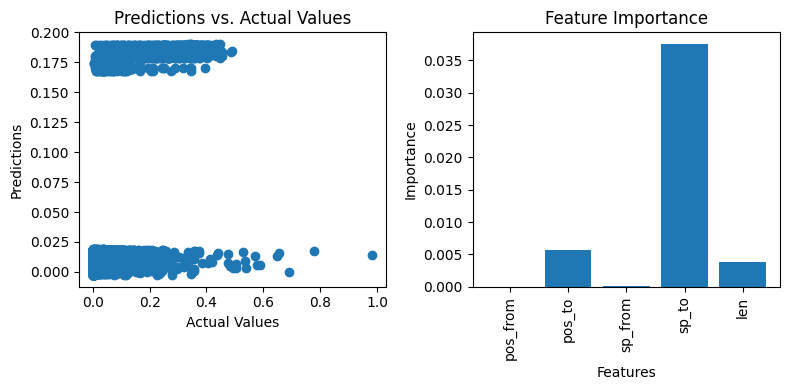

Y train mean: 0.43075323
Y test mean: 0.41927233
Mean cross val R2: 0.4435543369507883
Test R2: 0.3946520021105018

Predictions:
Pred = 0.005100858071354512 and target = 0.0038252531085163355


<ipython-input-27-195d770658cd>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


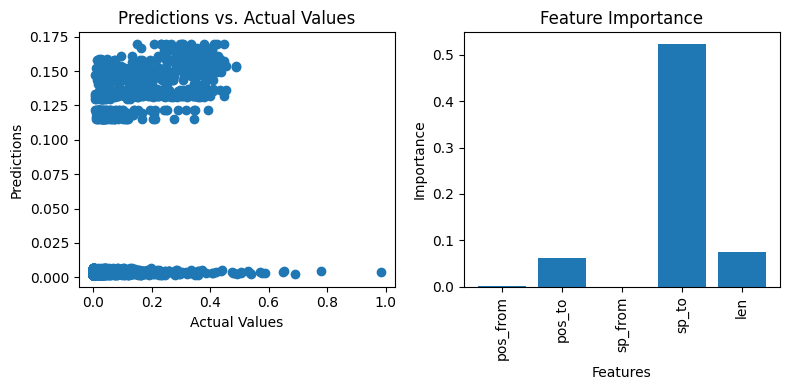

In [ ]:
lst_features = [0, 1, 2, 3, 4]
feature_names = ['pos_from', 'pos_to', 'sp_from', 'sp_to', 'len']
learn(Ridge(), id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
learn(Ridge(), log_scaler, log_reverse, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test, feature_names)
None

### poly (len, positions) (layer 9)

Y train mean: 0.01766931
Y test mean: 0.017740251
Mean cross val R2: 0.0825406856006505
Test R2: 0.091154049577991

Predictions:
Pred = 0.0025015826267558022 and target = 0.0019136577611789107


<ipython-input-70-195d770658cd>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


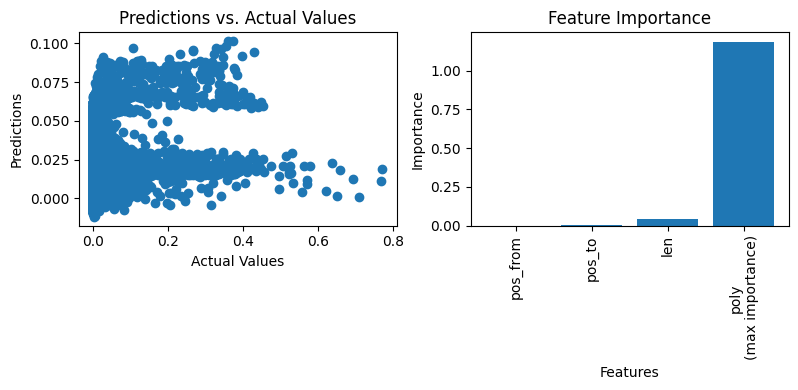

Y train mean: 0.42575267
Y test mean: 0.42527375
Mean cross val R2: 0.12578321660847855
Test R2: 0.01306925160317296

Predictions:
Pred = 0.006962340210149634 and target = 0.29988834261894226


<ipython-input-70-195d770658cd>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


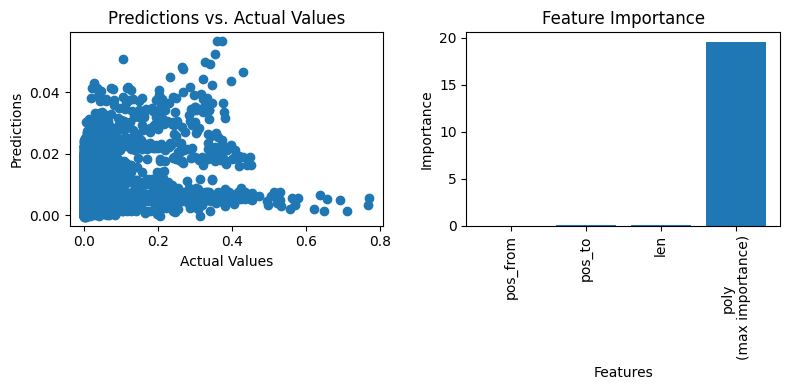

In [ ]:
lst_features = [0, 1, 4]
X_train_poly = PolynomialFeatures(degree=4).fit_transform(X_train[:, lst_features])
X_test_poly = PolynomialFeatures(degree=4).fit_transform(X_test[:, lst_features])
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [2], 'poly\n(max importance)': list(range(2,X_test_poly.shape[1]-3))}
learn(Ridge(), id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test,feature_names)
learn(Ridge(), log_scaler, log_reverse, X_train_poly, y_train, X_test_poly, y_test, feature_names)
None

## Round 3

### poly(pos + len + rev positions)

Y train mean: 0.01769374
Y test mean: 0.017827563
Mean cross val R2: 0.1468320342206548
Test R2: 0.1605387352104688

Predictions:
Pred = 0.023789029605418212 and target = 0.0009741215617395937


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


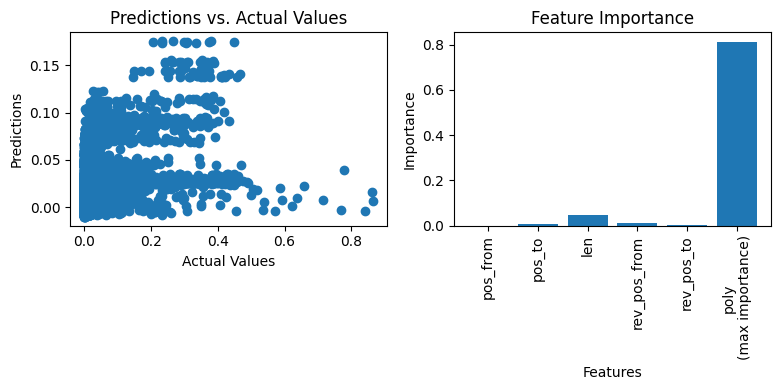

Y train mean: 0.42494953
Y test mean: 0.42876744
Mean cross val R2: 0.20764755500986531
Test R2: 0.08133817033768853

Predictions:
Pred = 0.00455723386595843 and target = 0.36479371786117554


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


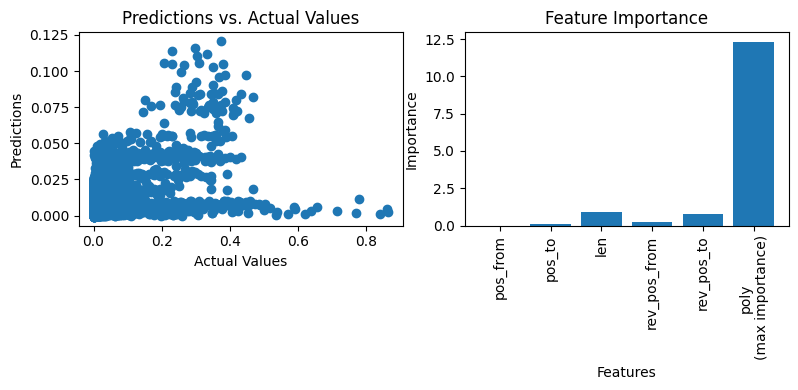

In [17]:
lst_features = [0, 1, 4, 6, 7]
X_train_poly = PolynomialFeatures(degree=4).fit_transform(X_train[:, lst_features])
X_test_poly = PolynomialFeatures(degree=4).fit_transform(X_test[:, lst_features])

feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [2], 'rev_pos_from': [3], 'rev_pos_to': [4],
                 'poly\n(max importance)': list(range(5,X_test_poly.shape[1]-5))}
learn(Ridge(), id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test,feature_names)
learn(Ridge(), log_scaler, log_reverse, X_train_poly, y_train, X_test_poly, y_test,feature_names)
None

### poly(pos + len + rel positions)

Y train mean: 0.01769374
Y test mean: 0.017827563
Mean cross val R2: 0.14533102920213997
Test R2: 0.15882674805177333

Predictions:
Pred = 0.08698774293065152 and target = 0.09728675335645676


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


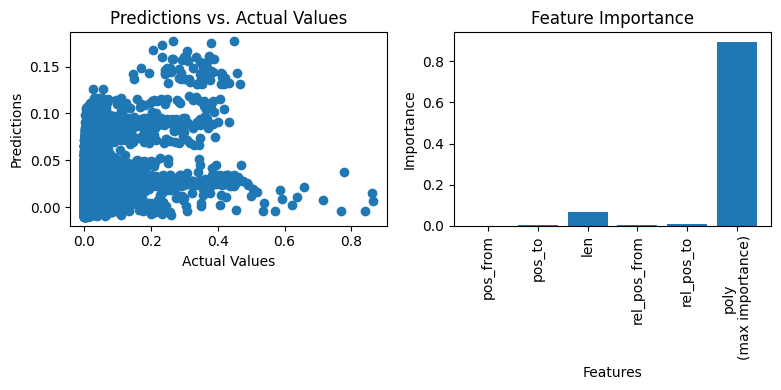

Y train mean: 0.42494953
Y test mean: 0.42876744
Mean cross val R2: 0.20602373791101963
Test R2: 0.07878334630071449

Predictions:
Pred = 0.0017810774749091984 and target = 0.21642835438251495


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


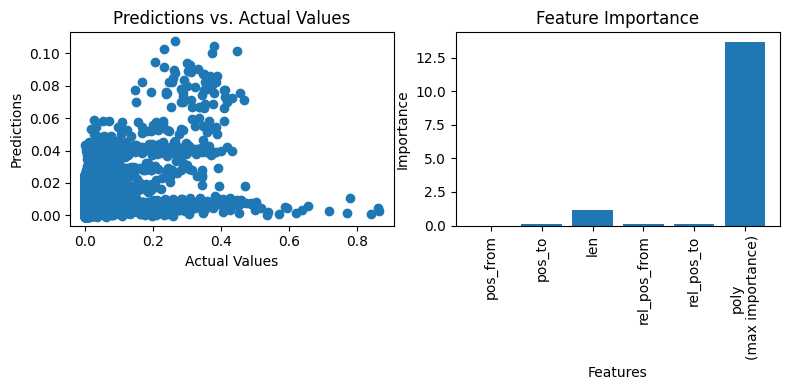

In [18]:
lst_features1 = [0, 1, 4, 5, 6]
X_train_poly = PolynomialFeatures(degree=4).fit_transform(X_train[:, lst_features1])
X_test_poly = PolynomialFeatures(degree=4).fit_transform(X_test[:, lst_features1])

feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [2], 'rel_pos_from': [3], 'rel_pos_to': [4],
                 'poly\n(max importance)': list(range(5,X_test_poly.shape[1]-5))}
learn(Ridge(), id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test,feature_names)
learn(Ridge(), log_scaler, log_reverse, X_train_poly, y_train, X_test_poly, y_test,feature_names)
None

### poly(pos + len + rel positions + reversed positions)  

Y train mean: 0.01772779
Y test mean: 0.018020261
Mean cross val R2: 0.16250591385967306
Test R2: 0.16491750009848782

Predictions:
Pred = 0.0235308334191852 and target = 0.0001023557415464893


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


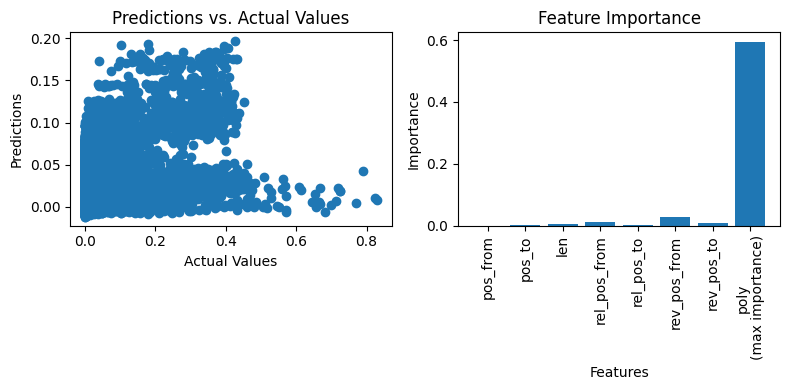

Y train mean: 0.4265724
Y test mean: 0.43790463
Mean cross val R2: 0.2243326901357121
Test R2: 0.09689896018175159

Predictions:
Pred = 0.012062829747923626 and target = 0.9074890613555908


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


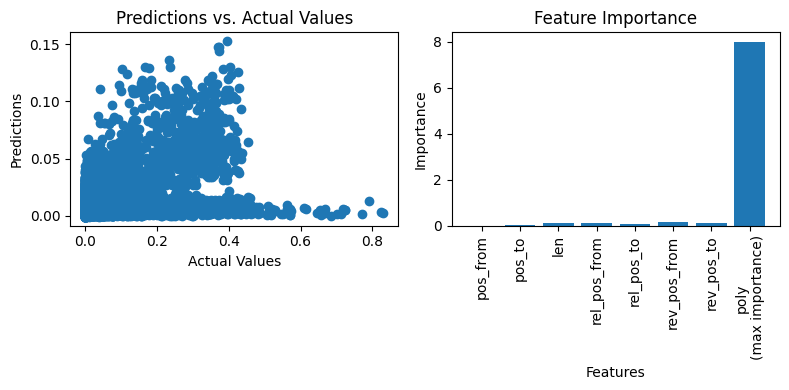

In [22]:
lst_features1 = [0, 1, 4, 5, 6, 7, 8]
X_train_poly = PolynomialFeatures(degree=4).fit_transform(X_train[:, lst_features1])
X_test_poly = PolynomialFeatures(degree=4).fit_transform(X_test[:, lst_features1])

feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [2], 'rel_pos_from': [3], 'rel_pos_to': [4], 'rev_pos_from': [5], 'rev_pos_to': [6],
                 'poly\n(max importance)': list(range(7,X_test_poly.shape[1]-7))}
learn(Ridge(), id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test,feature_names)
learn(Ridge(), log_scaler, log_reverse, X_train_poly, y_train, X_test_poly, y_test,feature_names)
None

### pos + len + rel positions + emb_to

Y train mean: 0.01769374
Y test mean: 0.017827563
Mean cross val R2: 0.4906699220518839
Test R2: 0.48104011636789046

Predictions:
Pred = 0.0023242274339854794 and target = 0.00017688579100649804


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


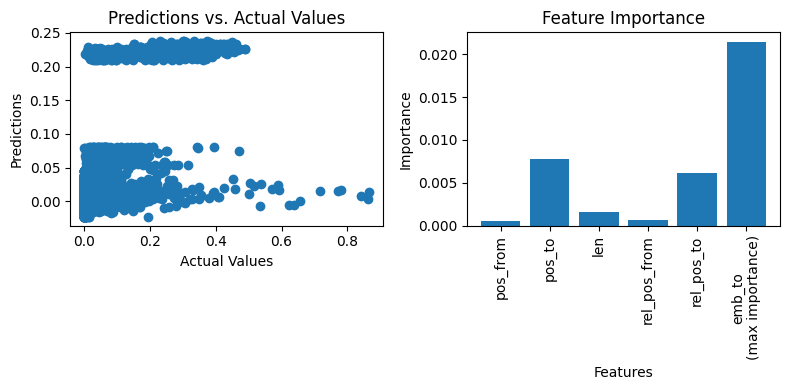

Y train mean: 0.42494953
Y test mean: 0.42876744
Mean cross val R2: 0.5919126596625472
Test R2: 0.4914625445583122

Predictions:
Pred = 0.0010822192933088836 and target = 0.19115965068340302


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


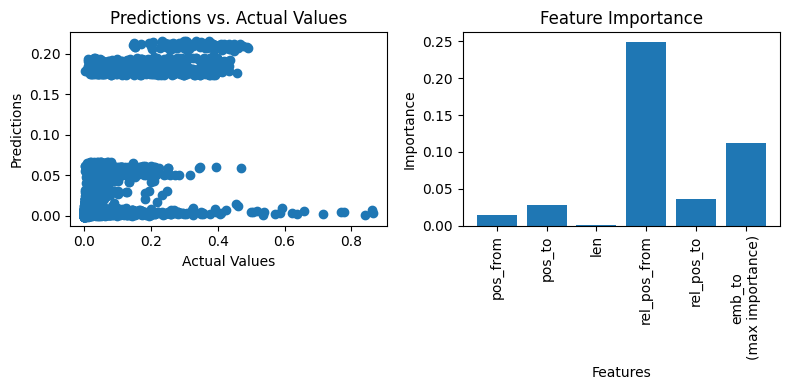

In [20]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [2], 'rel_pos_from': [3], 'rel_pos_to': [4],
                 'emb_to\n(max importance)': list(range(5,777-9))}

lst_features = [0, 1, 4, 5, 6] + list(range(9, 777))
learn(Ridge(), id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
learn(Ridge(), log_scaler, log_reverse, X_train, y_train, X_test, y_test,feature_names)
None

### pos + len + rev positions + emb_to

(pos form, pos to, is_from_special_token, is_to_special_token,

 len_of_seq, rel_position_from, rel_position_to, rev_pos_from,

 rev_pos_to, to_emb)


Y train mean: 0.01766931
Y test mean: 0.017740251
Mean cross val R2: 0.491070929214957
Test R2: 0.4782779281227534

Predictions:
Pred = 0.0031291078685762985 and target = 0.00021815458603668958


<ipython-input-70-195d770658cd>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


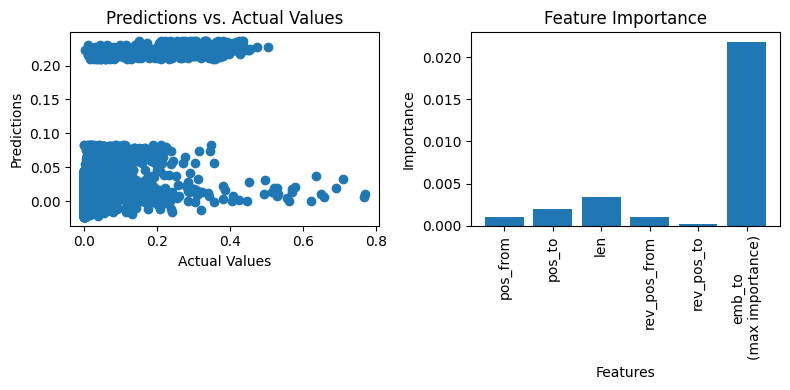

Y train mean: 0.42575267
Y test mean: 0.42527375
Mean cross val R2: 0.5935656603207733
Test R2: 0.4874227382641595

Predictions:
Pred = -0.0003471318775209964 and target = 0.07728642225265503


<ipython-input-70-195d770658cd>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


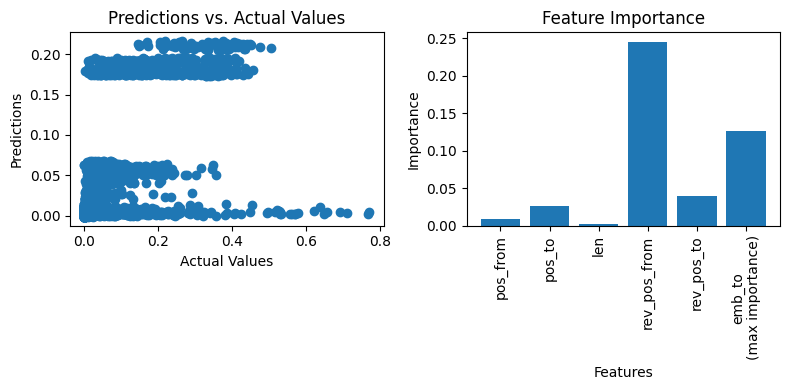

In [ ]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [2], 'rev_pos_from': [3], 'rev_pos_to': [4],
                 'emb_to\n(max importance)': list(range(5,777-9))}

lst_features = [0, 1, 4, 7, 8] + list(range(9, 777))
learn(Ridge(), id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
learn(Ridge(), log_scaler, log_reverse, X_train, y_train, X_test, y_test,feature_names)
None

### pos + len + rev positions + is_special_token

Y train mean: 0.017914524
Y test mean: 0.017696464
Mean cross val R2: 0.4146545386444503
Test R2: 0.3958434987308286

Predictions:
Pred = 0.0036941633851954123 and target = 0.002837748033925891


<ipython-input-28-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


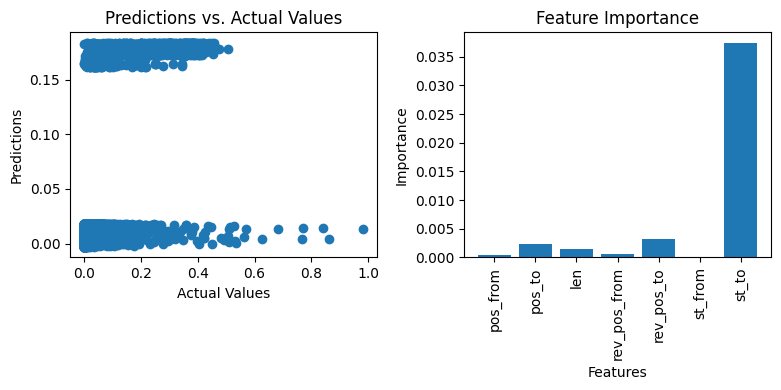

Y train mean: 0.42887875
Y test mean: 0.42597067
Mean cross val R2: 0.5969158024398775
Test R2: 0.4846426353159793

Predictions:
Pred = 0.006615830392238164 and target = 0.5417670011520386


<ipython-input-28-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


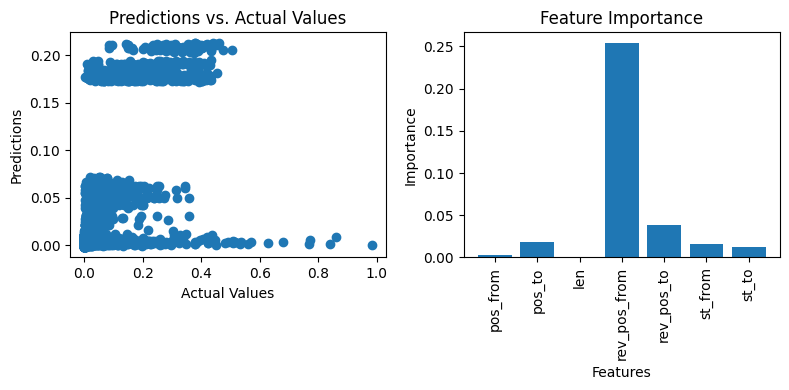

In [32]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [2], 'rev_pos_from': [3], 'rev_pos_to': [4],
                 'st_from': [5], 'st_to': [6]}

lst_features = [0, 1, 4, 7, 8, 2, 3]
learn(Ridge(), id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
learn(Ridge(), log_scaler, log_reverse, X_train, y_train, X_test, y_test,feature_names)
None

### pos + len + rel positions + is_special_token

Y train mean: 0.017914524
Y test mean: 0.017696464
Mean cross val R2: 0.41720426280437267
Test R2: 0.4005016453766489

Predictions:
Pred = 0.00662373936262403 and target = 0.004077615216374397


<ipython-input-28-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


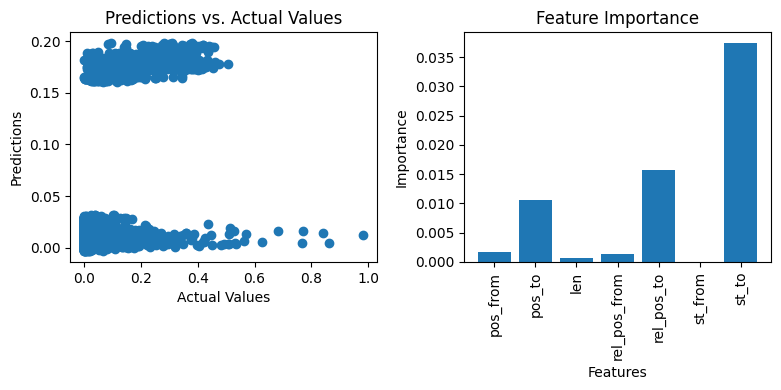

Y train mean: 0.42887875
Y test mean: 0.42597067
Mean cross val R2: 0.44547296080881293
Test R2: 0.3803159871054924

Predictions:
Pred = 0.0030453044996922294 and target = 0.0037784625310450792


<ipython-input-28-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


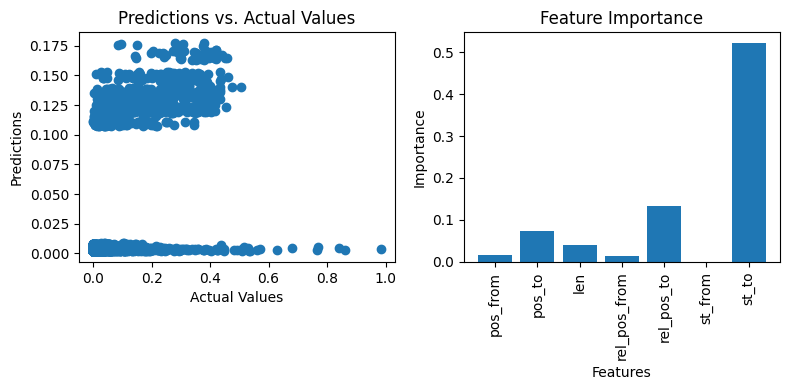

In [34]:
feature_names = ['pos_from','pos_to', 'len', 'rel_pos_from', 'rel_pos_to', 'st_from', 'st_to']

lst_features = [0, 1, 4, 5, 6, 2, 3]
learn(Ridge(), id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
learn(Ridge(), log_scaler, log_reverse, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
None

### pos + len + rel positions + emb_to + is_special_token

Y train mean: 0.017914524
Y test mean: 0.017696464
Mean cross val R2: 0.5005712927882268
Test R2: 0.4852062793110884

Predictions:
Pred = 0.01007139429202335 and target = 1.9828030417556874e-05


<ipython-input-28-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


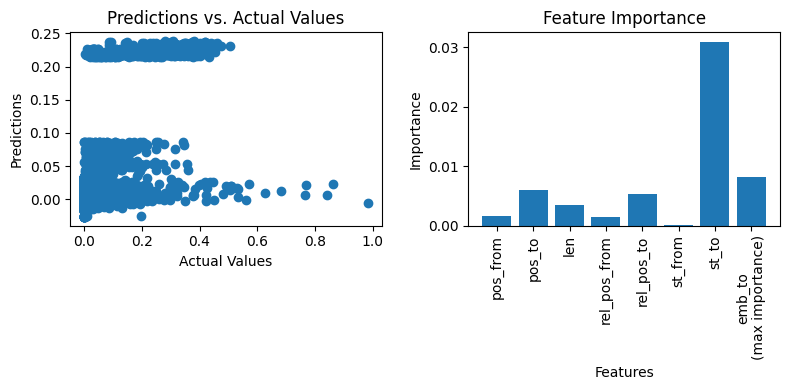

Y train mean: 0.42887875
Y test mean: 0.42597067
Mean cross val R2: 0.5969158024398775
Test R2: 0.4846426353159793

Predictions:
Pred = 0.003031219767033302 and target = 0.003837721887975931


<ipython-input-28-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


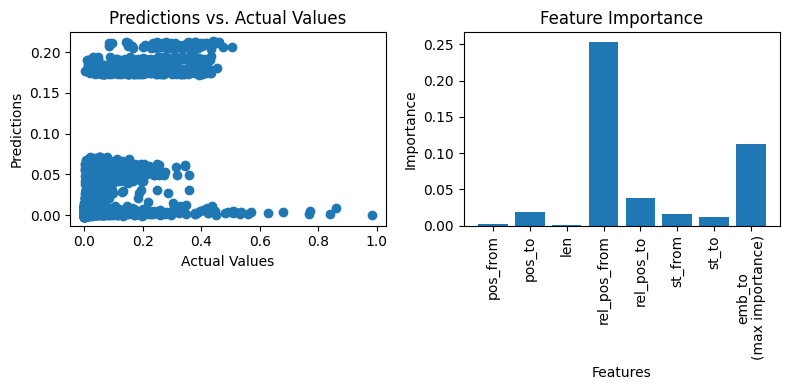

In [36]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [2], 'rel_pos_from': [3], 'rel_pos_to': [4],
                 'st_from': [5], 'st_to':[6], 'emb_to\n(max importance)': list(range(7, 777-9))}
lst_features = [0, 1, 4, 5, 6, 2, 3] + list(range(9,777))
learn(Ridge(), id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
learn(Ridge(), log_scaler, log_reverse, X_train, y_train, X_test, y_test,feature_names)
None

### pos + len + rev positions + emb_to + is_special_token

Y train mean: 0.017914524
Y test mean: 0.017696464
Mean cross val R2: 0.500330414784492
Test R2: 0.4844169688568787

Predictions:
Pred = 0.004257058547236859 and target = 0.0009085010387934744


<ipython-input-28-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


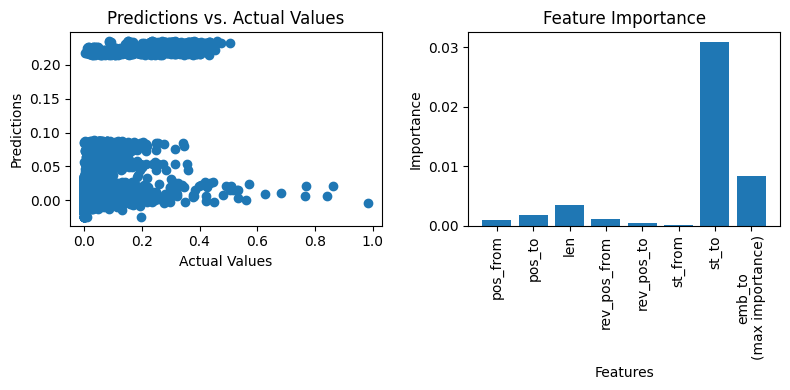

Y train mean: 0.42887875
Y test mean: 0.42597067
Mean cross val R2: 0.5969158024398775
Test R2: 0.4846426353159793

Predictions:
Pred = 0.005563547527072885 and target = 0.991656482219696


<ipython-input-28-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


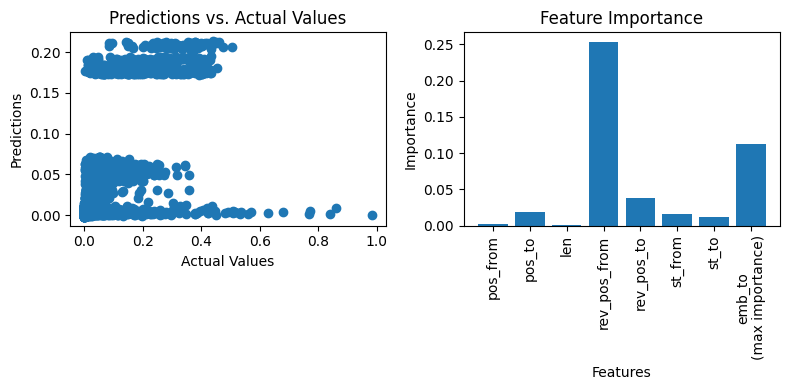

In [37]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [2], 'rev_pos_from': [3], 'rev_pos_to': [4],
                 'st_from': [5], 'st_to':[6], 'emb_to\n(max importance)': list(range(7, 777-9))}
lst_features = [0, 1, 4, 7, 8, 2, 3] + list(range(9,777))
learn(Ridge(), id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
learn(Ridge(), log_scaler, log_reverse, X_train, y_train, X_test, y_test,feature_names)
None

### pos + len + rev positions + rel positions + emb_to + is_special_token

Y train mean: 0.01772779
Y test mean: 0.018020261
Mean cross val R2: 0.5143185619502761
Test R2: 0.5509953117010895

Predictions:
Pred = 0.0015663783572939308 and target = 0.000545793620403856


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


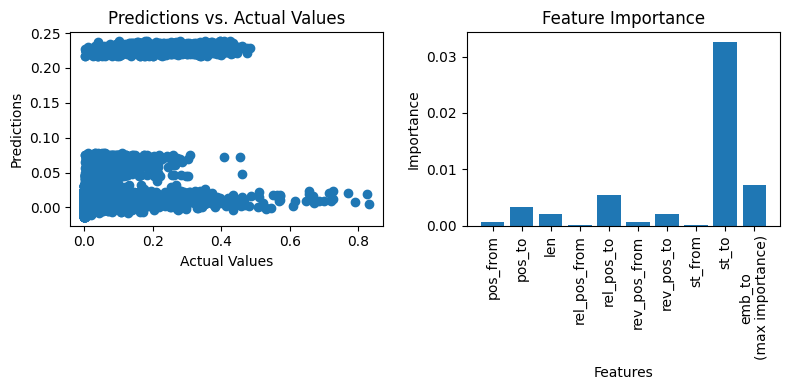

Y train mean: 0.4265724
Y test mean: 0.43790463
Mean cross val R2: 0.6081966970494745
Test R2: 0.5319921432933714

Predictions:
Pred = 0.0019417204890674134 and target = 0.01274794153869152


<ipython-input-9-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


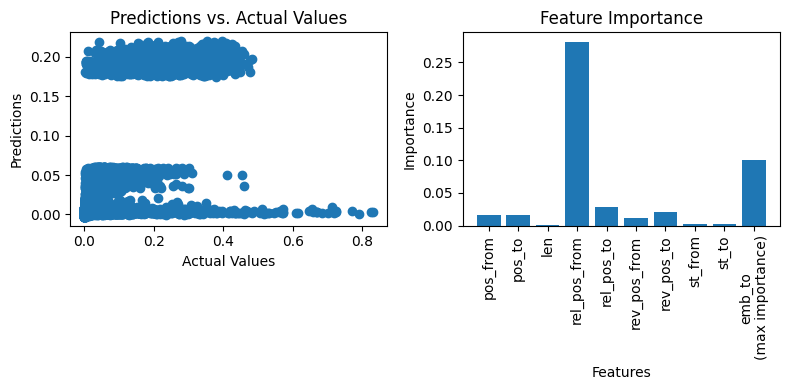

In [21]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [2], 'rel_pos_from': [3], 'rel_pos_to': [4],
                 'rev_pos_from': [5], 'rev_pos_to': [6],
                 'st_from': [7], 'st_to':[8], 'emb_to\n(max importance)': list(range(9, 777-9))}
lst_features = [0, 1, 4,5,6, 7, 8, 2, 3] + list(range(9,777))
learn(Ridge(), id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
learn(Ridge(), log_scaler, log_reverse, X_train, y_train, X_test, y_test,feature_names)
None

## Round Last

### poly(pos + len + rel positions + rev positions) + emb_to + is_special_token

Y train mean: 0.017935706
Y test mean: 0.01812496
Mean cross val R2: 0.5191356882921492
Test R2: 0.5264604528570798

Predictions:
Pred = 0.0034785986287414923 and target = 0.0020851364824920893


<ipython-input-8-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


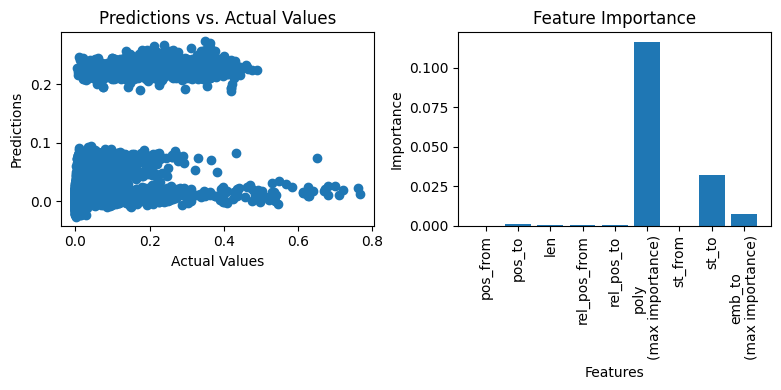

Y train mean: 0.42982832
Y test mean: 0.43355724
Mean cross val R2: 0.6111752859771225
Test R2: 0.5063796767793525

Predictions:
Pred = 0.0009507721473128638 and target = 0.0008946231100708246


<ipython-input-8-c39e09c29eff>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(feature_names, rotation=90)


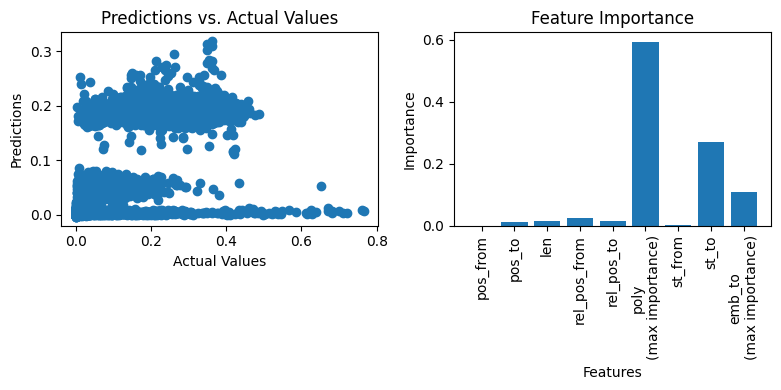

In [12]:
lst_features1 = [0, 1, 4, 5, 6, 7, 8]
X_train_poly = PolynomialFeatures(degree=4).fit_transform(X_train[:, lst_features1])
X_test_poly = PolynomialFeatures(degree=4).fit_transform(X_test[:, lst_features1])


lst_features2 = [2,3] + list(range(9, 777))
X_emb_train = X_train[:, lst_features2]
X_emb_test = X_test[:, lst_features2]
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [2], 'rel_pos_from': [3], 'rel_pos_to': [4], 'rel_pos_from': [5], 'rel_pos_to': [6],'rel_pos_from': [7], 'rel_pos_to': [8] ,
                 'poly\n(max importance)': list(range(9,X_test_poly.shape[1]-9)),
                 'st_from': [X_test_poly.shape[1]], 'st_to':[X_test_poly.shape[1]+1],
                 'emb_to\n(max importance)': list(range(X_test_poly.shape[1]+2,X_test_poly.shape[1]+X_emb_test.shape[1]))}
learn(Ridge(), id_scaler, id_scaler, np.concatenate((X_train_poly, X_emb_train), axis=1), y_train, np.concatenate((X_test_poly, X_emb_test), axis=1), y_test,feature_names)
learn(Ridge(), log_scaler, log_reverse, np.concatenate((X_train_poly, X_emb_train), axis=1), y_train, np.concatenate((X_test_poly, X_emb_test), axis=1), y_test,feature_names)
None

## Layer 3

In [ ]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=3, head_num=0)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X_train.shape, X_test.shape

3668it [07:43,  7.91it/s]


((2719093, 5), (586648, 5))

## Layer 7

In [ ]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=7, head_num=0)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X_train.shape, X_test.shape

3668it [07:47,  7.85it/s]


((2719506, 5), (587197, 5))

## Layer 11

In [ ]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=11, head_num=0)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X_train.shape, X_test.shape

3668it [07:44,  7.89it/s]


((2719366, 5), (587270, 5))